In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', None)


In [2]:

import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
# import tokenization
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [3]:

data = pd.read_csv("./all_final")
data.head()

sentences  \
0                                                                          The adhesive requires a setting time of 5 minutes for maximum bonding, except when there is loose fit between the extractor and the silver point.15   
1  In order to achieve an adequate seal the required depth will depend on the angle of bevel.11  An increased bevel requires a greater length of preparation to prevent leakage of irritants through exposed dentinal tubules.   
2                                                                                                                                             A deep palate allows much greater vertical access when using a palatal approach.   
3                                                                                                        This method allows a very precise removal of tooth substance and is continued until the root canal can be visualized.   
4                                             Iatrogenic problems causing inadequate cleaning of the root canal during primary treatment may lead to persistent infection and further difficulty if retreatment is required.     

   is_causal  
0          0  
1          0  
2          0  
3          0  
4          0

In [4]:
len(data)

5642

In [5]:
data[data['is_causal']==1]

sentences  \
4247                                                                                infection is the major cause of persistent periapical inflammation following root canal treatment   
4248                                                          The majority of calcium hydroxide powder remains as a slurry in water, and this can result in poor flow characteristics   
4249                                                                                  Haste in attaining a diagnosis can lead to treatment of the �wrong tooth� (Figures 1.45�1.47).    
4250  Iatrogenic problems causing inadequate cleaning of the root canal during primary treatment may lead to persistent infection and further difficulty if retreatment is required.    
4251                                               Repeated recapitulation or remaining stationary in the canal with a non-landed rotary instrument can lead to apical transportation   
...                                                                                                                                                                               ...   
5637                                                                           The preparation of a full crown frequently results in additional removal of sound tooth structure (Fig   
5638                 A significant difference of elastic modulus between the replacement material and the tissue replaced might result in inappropriate interfacial stress generation   
5639                          Furthermore, this pain can be further exacerbated by incorrect or unnecessary treatments, often resulting in the establishment of chronic pain pathways   
5640                                                               In most cases, fracture is caused by excessive engagement of the instrument in the canal and simultaneous rotation   
5641                    Furthermore, this pain can be further exacerbated by incorrect or unnecessary treatments frequently resulting in the establishment of chronic pain pathways.    

      is_causal  
4247          1  
4248          1  
4249          1  
4250          1  
4251          1  
...         ...  
5637          1  
5638          1  
5639          1  
5640          1  
5641          1  

[1395 rows x 2 columns]

# Naive Bayes Noop encoding

In [6]:
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set() # use seaborn plotting style

In [7]:
data = pd.read_csv("./all_final")
data.head()

sentences = list(data['sentences'])
label = list(data['is_causal'])



In [8]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np



In [33]:
def cross_validate(model, X, y, labels=['non-causal', 'causal']):
    skf = StratifiedKFold(n_splits=10)
    reports= []
    i = 1
    for train,test in skf.split(X, y):
        X_train = X[train]
        X_test = X[test]

        y_train = y[train]
        y_test = y[test]
        print("round " + str(i+1) + "/10 begin")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
#         print(classification_report(y_test, y_pred, target_names=['non-causal', 'causal']))
        report = classification_report(y_test, y_pred, target_names=['non-causal', 'causal'], output_dict=True)
        reports.append(report)
        print("round " + str(i+1) + "/10 completed")
        i+=1
    return model, reports

# SVM  && Naive Bayes && Random Forest with tfidf vectorize

In [34]:

def gen_vec(Corpus):

    # Step - a : Remove blank rows if any.
    Corpus['sentences'].dropna(inplace=True)
    # Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
    Corpus['sentences'] = [entry.lower() for entry in Corpus['sentences']]
    # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
    Corpus['sentences']= [word_tokenize(entry) for entry in Corpus['sentences']]
    # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    for index,entry in enumerate(Corpus['sentences']):
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text_final'
        Corpus.loc[index,'text_final'] = str(Final_words)


    np.random.seed(500)
    X = Corpus['text_final']
    y = Corpus['is_causal']
    
#     X_train, X_test, y_train, y_test = train_test_split(Corpus['text_final'], Corpus['is_causal'], test_size=0.33, random_state=42, stratify=label, shuffle=True)
    Encoder = LabelEncoder()
#     y_train = Encoder.fit_transform(y_train)
#     y_test = Encoder.fit_transform(y_test)
    y = Encoder.fit_transform(y)
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(Corpus['text_final'])
#     Train_X_Tfidf = Tfidf_vect.transform(X_train)
#     Test_X_Tfidf = Tfidf_vect.transform(X_test)
    X = Tfidf_vect.transform(X)

#     return Train_X_Tfidf, Test_X_Tfidf, y_train, y_test
    return X,y


In [35]:
Corpus = pd.read_csv("./all_final")
X, y = gen_vec(Corpus)

In [36]:
Naive = naive_bayes.MultinomialNB()
Naive,naive_report = cross_validate(Naive,X,y)


round 2/10 begin
round 2/10 completed
round 3/10 begin
round 3/10 completed
round 4/10 begin
round 4/10 completed
round 5/10 begin
round 5/10 completed
round 6/10 begin
round 6/10 completed
round 7/10 begin
round 7/10 completed
round 8/10 begin
round 8/10 completed
round 9/10 begin
round 9/10 completed
round 10/10 begin
round 10/10 completed
round 11/10 begin
round 11/10 completed


In [37]:
naive_report[0]

{'non-causal': {'precision': 0.816247582205029,
  'recall': 0.9929411764705882,
  'f1-score': 0.8959660297239915,
  'support': 425},
 'causal': {'precision': 0.9375,
  'recall': 0.32142857142857145,
  'f1-score': 0.47872340425531923,
  'support': 140},
 'accuracy': 0.8265486725663717,
 'macro avg': {'precision': 0.8768737911025145,
  'recall': 0.6571848739495798,
  'f1-score': 0.6873447169896554,
  'support': 565},
 'weighted avg': {'precision': 0.8462924290922785,
  'recall': 0.8265486725663717,
  'f1-score': 0.7925784765105152,
  'support': 565}}

In [74]:
def get_average_table(report_list):
    pcs_acc = 0
    rec_acc = 0
    f1_acc = 0

    accuracy_acc =0

    c_pcs_acc = 0
    c_rec_acc = 0
    c_f1_acc = 0
        
    w_pc = 0
    w_f1 = 0
    w_rec = 0
    for report in report_list:
        pcs_acc += report['non-causal']['precision']
        rec_acc += report['non-causal']['recall']
        f1_acc += report['non-causal']['f1-score']
        
        accuracy_acc += report['accuracy']
         
        w_pc += report['weighted avg']['precision']
        w_rec += report['weighted avg']['recall']
        w_f1 += report['weighted avg']['f1-score']

        
        c_pcs_acc += report['causal']['precision']
        c_rec_acc += report['causal']['recall']
        c_f1_acc += report['causal']['f1-score']
        
    print( ' '.join([str(float(x)/10) for x in [pcs_acc, rec_acc, f1_acc]]))
    print( ' '.join([str(float(x)/10) for x in [ c_pcs_acc, c_rec_acc, c_f1_acc]]))
    print(float(accuracy_acc)/10)

    print( 'weighted precision recall f1: \n' + ' '.join([str(float(x)/10) for x in [w_pc, w_f1, w_rec]]))

In [75]:
get_average_table(naive_report)

0.8125788459180019 0.9837497225305217 0.88990341900626
0.8563145939887427 0.30757451181911616 0.44821029357528425
0.81655243833553
weighted precision recall f1: 
0.8233772719000007 0.7806809287819273 0.81655243833553


In [38]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM, svm_report = cross_validate(SVM, X,y)

round 2/10 begin
round 2/10 completed
round 3/10 begin
round 3/10 completed
round 4/10 begin
round 4/10 completed
round 5/10 begin
round 5/10 completed
round 6/10 begin
round 6/10 completed
round 7/10 begin
round 7/10 completed
round 8/10 begin
round 8/10 completed
round 9/10 begin
round 9/10 completed
round 10/10 begin
round 10/10 completed
round 11/10 begin
round 11/10 completed


In [76]:
get_average_table(svm_report)

0.9537151107779532 0.943953385127636 0.9485639637290172
0.8383591018605078 0.8595015416238437 0.8470546343357699
0.9230807129856273
weighted precision recall f1: 
0.925173326563231 0.9234592631317117 0.9230807129856273


In [40]:
random_forest = RandomForestClassifier(n_estimators=1000, random_state=0)
random_forest, random_forest_report = cross_validate(random_forest, X,y)

round 2/10 begin
round 2/10 completed
round 3/10 begin
round 3/10 completed
round 4/10 begin
round 4/10 completed
round 5/10 begin
round 5/10 completed
round 6/10 begin
round 6/10 completed
round 7/10 begin
round 7/10 completed
round 8/10 begin
round 8/10 completed
round 9/10 begin
round 9/10 completed
round 10/10 begin
round 10/10 completed
round 11/10 begin
round 11/10 completed


In [77]:
get_average_table(svm_report)

0.9537151107779532 0.943953385127636 0.9485639637290172
0.8383591018605078 0.8595015416238437 0.8470546343357699
0.9230807129856273
weighted precision recall f1: 
0.925173326563231 0.9234592631317117 0.9230807129856273


# CNN

In [78]:
from sklearn.model_selection import train_test_split      
from keras.preprocessing.text import Tokenizer            
from keras.preprocessing.sequence import pad_sequences


sentences = data['sentences'].values
y = data['is_causal'].values

sentences_train,sentences_test,y_train,y_test = train_test_split(
                                                sentences, y,  
                                                test_size=0.3,  
                                                random_state=1000)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1   
maxlen = 100
# Train_X_Tfidf, Test_X_Tfidf, y_train, y_test = gen_vec(Corpus)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [79]:

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [80]:
from keras.models import Sequential
from keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          737900    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/10
395/395 [==============================] - 5s 11ms/step - loss: 0.3049 - accuracy: 0.8820 - val_loss: 0.2061 - val_accuracy: 0.9527
Epoch 2/10
395/395 [==============================] - 2s 5ms/step - loss: 0.1673 - accuracy: 0.9689 - val_loss: 0.1948 - val_accuracy: 0.9539
Epoch 3/10
395/395 [==============================] - 2s 5ms/step - loss: 0.1341 - accuracy: 0.9782 - val_loss: 0.1876 - val_accuracy: 0.9510
Epoch 4/10
395/395 [==============================] - 2s 5ms/step - loss: 0.1118 - accuracy: 0.9825 - val_loss: 0.2183 - val_accuracy: 0.9462
Epoch 5/10
395/395 [==============================] - 2s 5ms/step - loss: 0.0987 - accuracy: 0.9815 - val_loss: 0.2090 - val_accuracy: 0.9462
Epoch 6/10
395/395 [==============================] - 2s 5ms/step - loss: 0.0842 - accuracy: 0.9856 - val_loss: 0.1697 - val_accuracy: 0.9498
Epoch 7/10
395/395 [==============================] - 2s 5ms/step - loss: 0.0744 - accuracy: 0.9866 - val_loss: 0.2637 - val_accuracy: 0.9462
Epoch

53/53 - 1s - loss: 0.2677 - accuracy: 0.9462


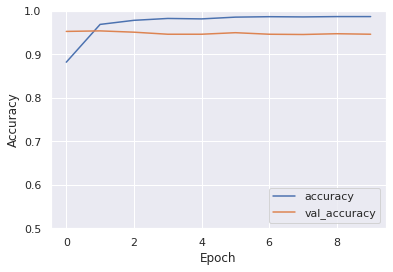

In [83]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [84]:
y_pred = model.predict(X_test)


In [85]:
labels = (y_pred > 0.5).astype(np.int)
print(labels)


[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [50]:
labels = np.array(labels)
labels.flatten()

array([0, 0, 0, ..., 0, 1, 0])

In [51]:
print("SVM Accuracy Score -> ",accuracy_score(labels, y_test)*100)
print(classification_report(labels, y_test))

SVM Accuracy Score ->  94.54287739192063
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1103
           1       0.83      0.94      0.88       308

    accuracy                           0.95      1411
   macro avg       0.91      0.95      0.92      1411
weighted avg       0.95      0.95      0.95      1411



# LSTM


In [52]:
print(tf.__version__)

2.2.0
